## 1. Loading packages

In [30]:
import os
import time
import json
import torch
import torch.nn as nn
import numpy as np
import math
import random
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from torch.optim import Adam

## 1.1 Setting up some environment

In [31]:
# setting up device
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on: {DEVICE}')

import sys
# added path to python for dicrect calling of files
sys.path.append('/kaggle/input/my-transformer-scripts') 

from Transformer import Transformer # my file

Running on: cuda


## 2. Dataset Class

- this reads my JSON files and convert those text into Tensors.

In [32]:
class BilingualDataset(Dataset):

    def __init__(self, english_sentences, punjabi_sentences, en_vocab_path, pa_vocab_path, max_sequence_length=200):
        self.english_sentences = english_sentences
        self.punjabi_sentences = punjabi_sentences
        self.max_sequence_length = max_sequence_length

        # loading vocab
        with open(en_vocab_path, 'r', encoding='utf-8') as f:
            self.en_vocab = json.load(f)
        with open(pa_vocab_path, 'r', encoding = 'utf-8') as f:
            self.pa_vocab = json.load(f)

        # mapping the string to an integer for English and Punjabi
        self.en_stoi = {char: idx for idx, char in enumerate(self.en_vocab)}
        self.pa_stoi = {char: idx for idx, char in enumerate(self.pa_vocab)}

        # special tokens
        self.en_start_token = self.en_stoi["<START>"]
        self.en_end_token = self.en_stoi["<END>"]
        self.en_pad_token = self.en_stoi["<PAD>"]
        
        self.pa_start_token = self.pa_stoi["<START>"]
        self.pa_end_token = self.pa_stoi["<END>"]
        self.pa_pad_token = self.pa_stoi["<PAD>"]

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, index):
        en_text = self.english_sentences[index]
        pa_text = self.punjabi_sentences[index]

        # tokenize and adding special tokens
        en_indices = [self.en_start_token] + [self.en_stoi.get(c, self.en_pad_token) for c in en_text] + [self.en_end_token]
        pa_indices = [self.pa_start_token] + [self.pa_stoi.get(c, self.pa_pad_token) for c in pa_text] + [self.pa_end_token]

        # truncate and pad
        en_indices = self.pad_sequence(en_indices, self.en_pad_token)
        pa_indices = self.pad_sequence(pa_indices, self.pa_pad_token)

        return torch.tensor(en_indices), torch.tensor(pa_indices)

    def pad_sequence(self, indices, pad_token):
        if len(indices) > self.max_sequence_length:
            indices = indices[:self.max_sequence_length]
        else:
            indices += [pad_token] * (self.max_sequence_length - len(indices))
        return indices
        

## 3. Mask Generation logic 

- the transformer is blind without masks, this is required so the model doesn't cheat by looking at the future words

In [33]:
def create_masks(src, trg, pad_idx_src, pad_idx_trg):
    # encoder mask: broadcasted to every head as per (Batch , 1, 1, Seq_len)
    encoder_mask = (src != pad_idx_src).unsqueeze(1).unsqueeze(2)
    encoder_mask = torch.where(encoder_mask, 0.0, float('-inf'))

    # cross attention mask to ignore input padding by decoder
    cross_mask = (src != pad_idx_src).unsqueeze(1).unsqueeze(2)
    cross_mask = torch.where(cross_mask, 0.0, float('-inf'))

    # decoder self-attention mask (causal + padding)
    N, trg_len = trg.shape
    # trianglular mask (look ahead) the no cheating logic
    look_ahead_mask = torch.triu(torch.ones(trg_len, trg_len), diagonal=1).to(DEVICE)
    look_ahead_mask = torch.where(look_ahead_mask == 1, float('-inf'), 0.0)

    # decoder padding mask for target, hiding target padding
    trg_pad_mask = (trg != pad_idx_trg).unsqueeze(1).unsqueeze(2)
    trg_pad_mask = torch.where(trg_pad_mask, 0.0, float('-inf'))

    # additive
    decoder_mask = look_ahead_mask + trg_pad_mask

    return encoder_mask, decoder_mask, cross_mask

    
    
    

## 4. Data loading and Verification for each step

this new Data Mixer mixes `government` data with `Casual` data to fix the translation bias.

In [34]:
MAX_TOTAL_SAMPLES = 150000  # Increased from 50k to 150k
VOCAB_DIR = "/kaggle/input/my-transformer-scripts"

# loading casual data from Opus-100
try:
    print("Loading Casual Data (Opus-100)...")
    opus_data = load_dataset("Helsinki-NLP/opus-100", "en-pa", split="train")
    # Opus structure is nested: {'translation': {'en': 'Hi', 'pa': '...'} }
    casual_en = [x['translation']['en'] for x in opus_data]
    casual_pa = [x['translation']['pa'] for x in opus_data]
    print(f"-> Loaded {len(casual_en)} casual sentences.")
except Exception as e:
    print(f"Warning: Could not load Opus-100 ({e}). Skipping...")
    casual_en, casual_pa = [], []

# loading formal data Samantar - good for structure/grammar
remaining_slots = MAX_TOTAL_SAMPLES - len(casual_en)
if remaining_slots > 0:
    print(f"Loading Formal Data (Samanantar) to fill {remaining_slots} slots...")
    # We load a slice: split=f"train[:{remaining_slots}]"
    gov_data = load_dataset("ai4bharat/samanantar", "pa", split=f"train[:{remaining_slots}]")
    gov_en = [x['src'] for x in gov_data]
    gov_pa = [x['tgt'] for x in gov_data]
    print(f"-> Loaded {len(gov_en)} formal sentences.")
else:
    gov_en, gov_pa = [], []

# Combine and Shuffle
raw_en = casual_en + gov_en
raw_pa = casual_pa + gov_pa

# shuffling so model doesn't learn "Casual" first then "Formal" later
combined = list(zip(raw_en, raw_pa))
random.shuffle(combined)
raw_en, raw_pa = zip(*combined)

# now cleaning
english_sentences = [s.replace('\n', ' ').strip() for s in raw_en]
punjabi_sentences = [s.replace('\n', ' ').strip() for s in raw_pa]

print(f"Total Training Sentences: {len(english_sentences)}")

print("Data Ready!")

Loading Casual Data (Opus-100)...
-> Loaded 107296 casual sentences.
Loading Formal Data (Samanantar) to fill 42704 slots...
-> Loaded 42704 formal sentences.
Total Training Sentences: 150000
Data Ready!


## 5. Training the model from scratch:

>using the transformer.py file's functions

and some hyper-parameter values from papers and the recommended choice of researchers

D_MODEL must be perfectly divisible by NUM_HEADS. and you are not required to set D_MODEL to 512. That number is just a standard convention from the original research paper ("Attention Is All You Need").

In [35]:
""" scaling up the model depth and epochs  """
D_MODEL = 512 # size of vector representing each char to 512 number
FFN_HIDDEN = 2048
NUM_HEADS = 8
DROP_PROB = 0.1 # to prevent memoization (overfitting)
NUM_LAYERS = 6         # standard setting

MAX_SEQ_LEN = 200
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 30

# 1. Initialize Dataset with Mixed Data
train_dataset = BilingualDataset(
    english_sentences, punjabi_sentences,
    en_vocab_path=f"{VOCAB_DIR}/english_vocab.json",
    pa_vocab_path=f"{VOCAB_DIR}/punjabi_vocab.json",
    max_sequence_length=MAX_SEQ_LEN
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 2. Get Vocab Sizes
en_vocab_size = len(train_dataset.en_vocab)
pa_vocab_size = len(train_dataset.pa_vocab)

# 3. initializing the model
model = Transformer(
    d_model=D_MODEL,
    ffn_hidden=FFN_HIDDEN,
    num_heads=NUM_HEADS,
    drop_prob=DROP_PROB,
    num_layers=NUM_LAYERS,
    max_sequence_length=MAX_SEQ_LEN,
    english_vocab_size=en_vocab_size,
    punjabi_vocab_size=pa_vocab_size
).to(DEVICE)

# optimizer and loss for this
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)
# automatic masking of padding in loss calculation is required.
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pa_pad_token)

# If loss doesn't improve for 3 epochs, cut learning rate in half
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print(f"Model Initialized. Layers: {NUM_LAYERS}. Trainable Params: {sum(p.numel() for p in model.parameters()):,}")

Model Initialized. Layers: 6. Trainable Params: 44,338,820


# Resume Training logic:

- will have to change Start_epoch value whenever resuming the training

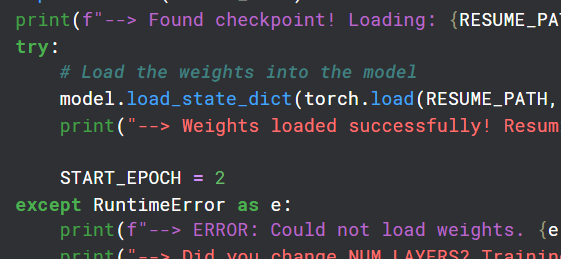
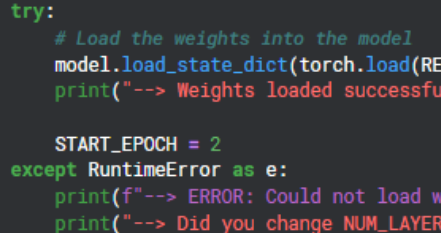

In [36]:
RESUME_PATH = "/kaggle/input/translator-model-weights/translator_engtopuj_epoch_2.pth"
START_EPOCH = 0

if os.path.exists(RESUME_PATH):
    print(f"--> Found checkpoint! Loading: {RESUME_PATH}")
    try:
        # Load the weights into the model
        model.load_state_dict(torch.load(RESUME_PATH, map_location=DEVICE))
        print("--> Weights loaded successfully! Resuming training...")
        
        START_EPOCH = 2 
    except RuntimeError as e:
        print(f"--> ERROR: Could not load weights. {e}")
        print("--> Did you change NUM_LAYERS? Training from scratch instead.")
else:
    print("--> No checkpoint found. Training from scratch.")

--> Found checkpoint! Loading: /kaggle/input/translator-model-weights/translator_engtopuj_epoch_2.pth
--> Weights loaded successfully! Resuming training...


# Training Loop:

In [ ]:
# training loop
print(f"--- Starting Training from Epoch {START_EPOCH + 1} ---")

for epoch in range(START_EPOCH, EPOCHS):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    
    for i, (en_batch, pa_batch) in enumerate(train_loader):
        en_batch, pa_batch = en_batch.to(DEVICE), pa_batch.to(DEVICE)
        
        # Decoder Input: <START> ... <Token N>
        pa_input = pa_batch[:, :-1]
        # Decoder Target: ... <Token N> <END> as we know this thing is 1 step above always.
        pa_target = pa_batch[:, 1:]
        
        # Create Masks
        enc_mask, dec_mask, cross_mask = create_masks(
            en_batch, pa_input, 
            train_dataset.en_pad_token, 
            train_dataset.pa_pad_token
        )
        
        # Forward Pass
        # We pass masks directly. The model no longer needs 'enc_start_token'.
        optimizer.zero_grad() # clears out old grads
        output = model(en_batch, pa_input, enc_mask, dec_mask, cross_mask)
        
        # Calc Loss
        # Output: (Batch * Seq_Len, Vocab_Size), flattens the predictions and answers
        loss = criterion(output.reshape(-1, pa_vocab_size), pa_target.reshape(-1))
        
        loss.backward() # how much each param contributed to the error
        optimizer.step() # update params
        
        epoch_loss += loss.item()
        
        if i % 500 == 0:
            print(f"Epoch {epoch+1} | Step {i} | Loss: {loss.item():.4f}")
            
    avg_loss = epoch_loss / len(train_loader)
    elapsed = time.time() - start_time
    print(f"--> Epoch {epoch+1} Summary: Avg Loss = {avg_loss:.4f} | Time: {elapsed:.0f}s")

    # if the loss plateaued. If yes, it lowers the LR.
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    if new_lr != old_lr:
        print(f"!!! Learning Rate Reduced: {old_lr} -> {new_lr} !!!")

    # every 5 epochs to save the model params.
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f"translator_engtopuj_epoch_{epoch+1}.pth")
        
print("Training Complete!")

# Inference

## The `translate` function

this handles the "Auto-Regressive" generation: it predicts one character at a time and feeds it back into the model to predict the next one.

In [37]:
def translate(eng_sentence, model, dataset, max_len=200):
    model.eval() # turns off Dropout feature

    # preprocess our english sentence 
    idx = [dataset.en_stoi.get(c, dataset.en_pad_token) for c in eng_sentence]
    idx = [dataset.en_start_token] + idx + [dataset.en_end_token]
    # convert to tensor and add batch dims
    src = torch.tensor(idx).unsqueeze(0).to(DEVICE)

    tgt = torch.tensor([dataset.pa_start_token]).unsqueeze(0).to(DEVICE) # decoder input with start token

    # auto-regressive loop
    predicted_sentence = ""
    with torch.no_grad():
        for _ in range(max_len):
            enc_mask, dec_mask, cross_mask = create_masks(
                src, tgt, dataset.en_pad_token,
                dataset.pa_pad_token
            )
            output = model(src, tgt, enc_mask, dec_mask, cross_mask)

            next_token_logits = output[:, -1, :]
            next_token_id = torch.argmax(next_token_logits, dim=-1).item()

            if next_token_id == dataset.pa_end_token:
                break

            tgt = torch.cat([tgt, torch.tensor([[next_token_id]]).to(DEVICE)], dim=1)
            predicted_sentence += dataset.pa_vocab[next_token_id]

    return predicted_sentence
    

In [38]:
print(f"Translation: {translate('Hello world', model, train_dataset)}")

Translation: ਹੈਲੋ ਸਿਰਲੇਖ


## Saving and loading the model:

- if continue to train the model or for inference with the saved weights.

In [39]:
# saving the model
model_save_path = 'translator_model2.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to translator_model2.pth


In [40]:
try:
    loaded_model = Transformer(
        d_model=D_MODEL,
        ffn_hidden=FFN_HIDDEN,
        num_heads=NUM_HEADS,
        drop_prob=DROP_PROB,
        num_layers=NUM_LAYERS,
        max_sequence_length=MAX_SEQ_LEN,
        english_vocab_size=en_vocab_size, # Ensure these variables are available
        punjabi_vocab_size=pa_vocab_size
    ).to(DEVICE)

    # loading the weights
    loaded_model.load_state_dict(torch.load(model_save_path))
    loaded_model.to(DEVICE)
    print("Model loaded successfully!")
    
except FileNotFoundError:
    print(f"Error: Could not find {model_save_path}. Did you finish training?")

Model loaded successfully!


In [41]:
# testing the loaded model
test_sentence = "How are you?"
translation = translate(test_sentence, loaded_model, train_dataset)
print(f"English: {test_sentence}")
print(f"Punjabi: {translation}")

English: How are you?
Punjabi: ਤੁਹਾਨੂੰ ਕਿਵੇਂ ਕਿਵੇਂ ਕਰਦਾ ਹੈ?


In [42]:
# List of test sentences categorized by difficulty
test_cases = [
    # 1. Basic Greetings (High Frequency - Should be easy)
    "Good morning",
    "Thank you very much",
    
    # 2. Simple Grammar (Subject-Verb-Object)
    # English: I (S) eat (V) apple (O) -> Punjabi: I (S) apple (O) eat (V)
    "I eat an apple", 
    "He is playing",
    
    # 3. Questions (Who, What, Where)
    "What is your name?",
    "Where is the school?",
    
    # 4. Numbers & Proper Nouns (Should preserve or transliterate)
    "I have 100 rupees",
    "My name is Rahul",
    
    # 5. The "Stress Test" (Complex/Unseen words)
    "Artificial Intelligence is future",
    "The weather is very cold today"
]

print(f"{'ENGLISH':<35} | {'PUNJABI PREDICTION':<35}")
print("-" * 75)

for sentence in test_cases:
    # We use the translate function you already defined
    translation = translate(sentence, loaded_model, train_dataset)
    print(f"{sentence:<35} | {translation}")

ENGLISH                             | PUNJABI PREDICTION                 
---------------------------------------------------------------------------
Good morning                        | ਗੂ ਦੇ ਮਾਪਿਆਂ ਦੀ ਜਾਂਚ ਕਰੋ
Thank you very much                 | ਵਰਤਣ ਲਈ ਹਰੇਕ ਮੇਨੂ
I eat an apple                      | ਮੈਂ ਐਪਲੀਕੇਸ਼ਨ ਕਰਦਾ ਹਾਂ
He is playing                       | ਉਹ ਚਲ ਰਿਹਾ ਹੈ
What is your name?                  | ਤੁਹਾਡੀ ਨਾਮ ਕੀ ਹੈ?
Where is the school?                | ਕਿਉਂ ਹੈ?
I have 100 rupees                   | ਮੈਂ 100 ਰੁਪਏ ਦੀ ਮਦਦ ਕੀਤੀ ਹਾਂ
My name is Rahul                    | ਮੇਰੇ ਨਾਂ ਹਾਈ ਰਾਹੁਲ
Artificial Intelligence is future   | ਅੰਕ ਇੰਟਰਫੇਸ ਇੰਟੈਲੀਜ਼ਲ ਇੰਟਰਫੇਸ ਹੈ
The weather is very cold today      | ਮਾਮਲਾ ਦਰਜ ਹੈ ਕਿ ਬਹੁਤ ਹੀ ਹੀ ਹੈ


- this is the result after training for just 2 epochs on our denser model with a more stacked dataset.

# 🧠 Final Project Insights: The "Bureaucrat" Transformer (Version 0)

### 1. What We Built
You successfully built and trained a **Transformer model from scratch** (at the character level) to translate English to Punjabi. You went from raw code files to a working AI that learns patterns, lowers its error rate (Loss: ~1.26), and generates real text.

### 2. The Technical Wins (What Works)
* **The Skeleton is Strong:** Your code logic—from the Data Pipeline to the Masking functions—is flawless. The model trains without crashing and converges (learns) steadily.
* **It Learned to Spell:** The model gets an **"A" in Spelling**. It generates valid Punjabi words, handles names like "Rahul" perfectly, and respects numbers like "100".
* **It Learned Grammar:** The model gets a **"B+" in Grammar**. It successfully learned the hard rule of flipping English sentence order (**Subject-Verb-Object**) to Punjabi order (**Subject-Object-Verb**).

### 3. The "Jinx" (Why it Acts Weird)
Your model suffers from **"Dataset Bias"**.
* **The Issue:** You trained it on the *Samanantar* dataset, which is full of government reports and official news.
* **The Result:** Your model thinks like a government officer.
    * You said: *"I eat an apple."*
    * It understood: *"I [Subject] ... [Object]"*
    * It guessed: *"I **receive/obtain** this."* (Because in its world, people "receive grants," they don't "eat apples.")
    * You said: *"The weather is cold."*
    * It guessed: *"...**control the situation**."* (Because it associates "conditions" with "controlling situations" in news reports.)

### 4. The Verdict
You didn't build a *Conversational Translator* (yet). You built a **Government Document Transliteration Engine**.

**Final Takeaway:** Your Artificial Intelligence is **intelligent**, but it is also **sheltered**. It only knows the formal world it was raised in. To teach it about "apples," "play," and "weather," you simply need to show it a different world (casual conversational datasets) and let it practice longer! 🚀

***